# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

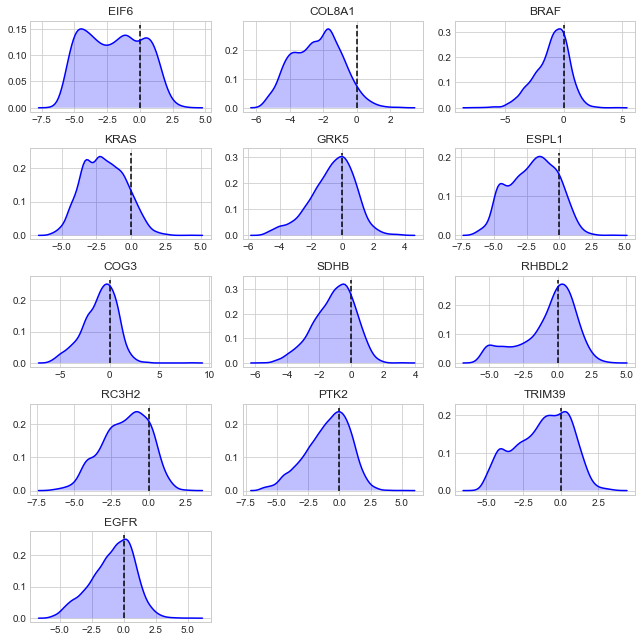

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

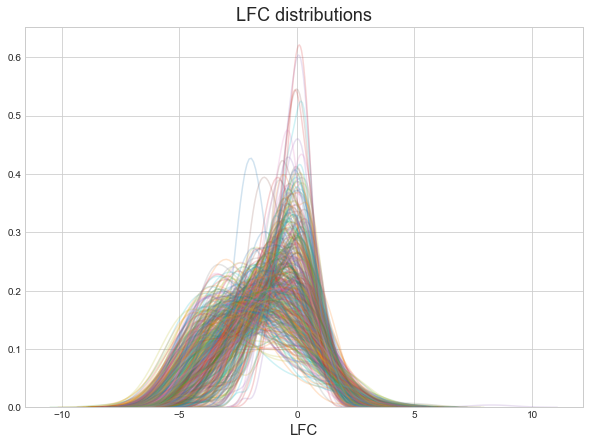

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

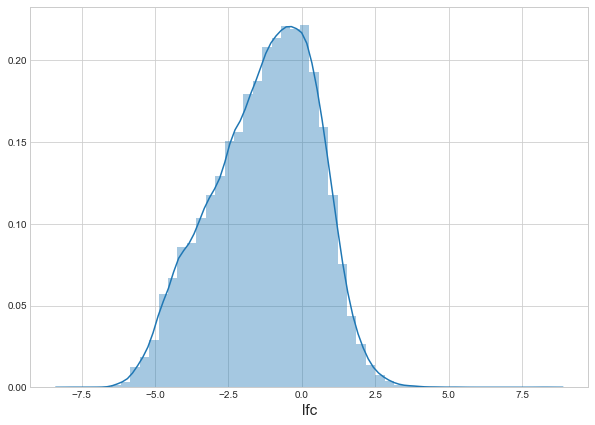

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


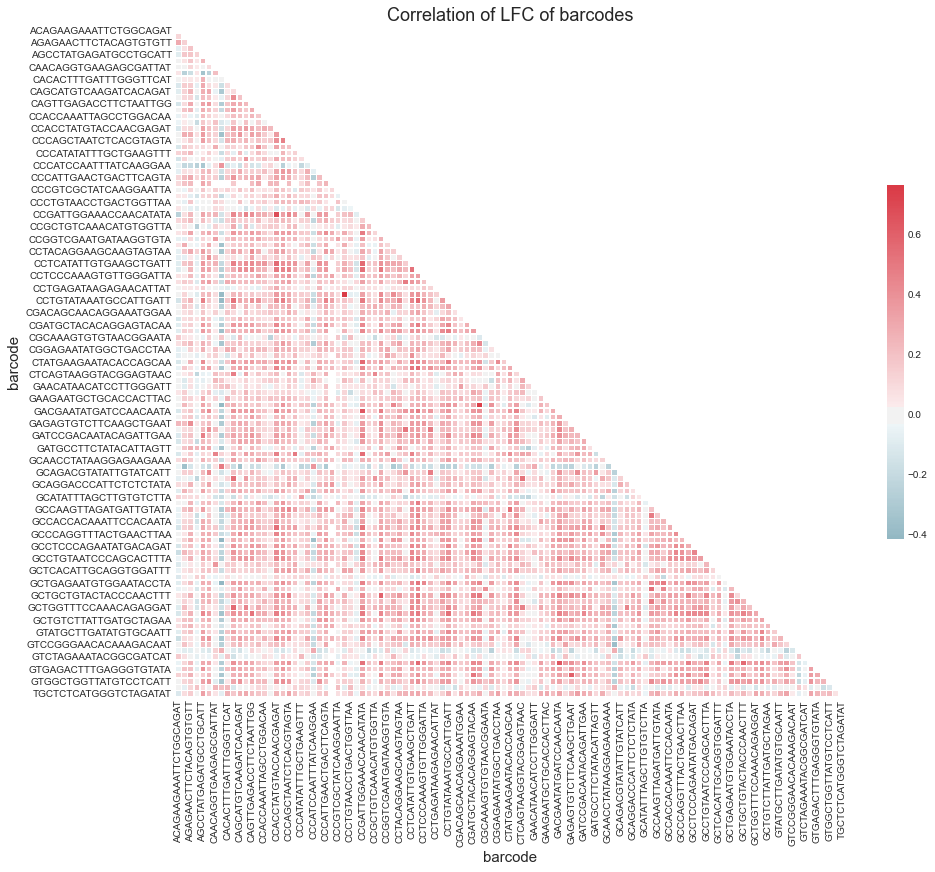

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 20)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(1810, 5)

In [12]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,7,5
1,ACAGAAGAAATTCTGGCAGAT,dbtrg05mg_central_nervous_system,2.145082,2,EIF6,1,6,5
2,ACAGAAGAAATTCTGGCAGAT,bt20_breast,0.932751,2,EIF6,1,2,5
3,ACAGAAGAAATTCTGGCAGAT,calu1_lung,1.519675,2,EIF6,1,3,5
4,ACAGAAGAAATTCTGGCAGAT,opm2_haematopoietic_and_lymphoid_tissue,0.509560,2,EIF6,1,17,5


Binary matrix of $[shRNA \times gene]$.

In [13]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [14]:
shrna_gene_matrix.shape

(109, 13)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [21]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc,
    'N_pred': 2000
}

**Compile model.**

In [24]:
start = timer()
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = pystan.StanModel(file=d2_stan_file.as_posix())
end = timer()
print(f'{(end - start) / 60:.2f} minutes to compile model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b11863617a420c9feee8f0a4b509b7c NOW.


1.13 minutes to compile model


In [25]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [27]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [29]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.221,0.037,-1.286,-1.146,0.001,0.001,1706.0,1704.0,1705.0,1483.0,1.0
sigma,1.641,0.027,1.591,1.693,0.001,0.000,1672.0,1671.0,1671.0,1299.0,1.0


In [32]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'})

TypeError: `data` argument must have the group "observed_data" for ppcplot